In [1]:
import pickle
import os

import math
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

# !pip install torchinfo
from torchinfo import summary
from sklearn.model_selection import train_test_split

import tqdm
from tqdm.auto import trange
import matplotlib.pyplot as plt

In [2]:
# !ls
device_id = 0 if torch.cuda.is_available() else 'cpu'
device = torch.device(device_id)
device

device(type='cpu')

In [3]:
### LOAD DATA
bootstrap_splits = 10

for split in range(bootstrap_splits):
    # Load data for current bootstrap (X_train, X_test contain indices of Videos, and y_train, y_test contain human rating labels)
    with open('./PHASE/bootstrapped_traintest_splits_pickles/XY_Apr30_humanratings_'+str(split), "rb") as f:
        X_train = pickle.load(f)
        y_train = pickle.load(f)
        X_test = pickle.load(f)
        y_test = pickle.load(f)
    print("Bootstrap No.:",split)
    if split == 0:
        print("The training datasize is {}".format(len(X_train)))
        print("Samples of training data is {}".format(X_train[:10]))

Bootstrap No.: 0
The training datasize is 300
Samples of training data is [319, 260, 322, 25, 38, 268, 131, 45, 179, 256]
Bootstrap No.: 1
Bootstrap No.: 2
Bootstrap No.: 3
Bootstrap No.: 4
Bootstrap No.: 5
Bootstrap No.: 6
Bootstrap No.: 7
Bootstrap No.: 8
Bootstrap No.: 9


# Load the raw data

In [4]:
video_path = "./PHASE/Videos_humanratings"
with open(video_path, 'rb') as f:
    videos = pickle.load(f)

In [5]:
print("The length of videos is {}".format(len(videos)))
print("The keys are {}".format(videos[0].keys()))
print("    Example name is {}".format(videos[0]["name"]))
print("    Example entity_size is {}".format(videos[0]["entity_sizes"]))
print("    Example entity_color_code is {}".format(videos[0]["entity_color_code"]))
print("    Example physical_goals is {}".format(videos[0]["physical_goals"]))
print("    Example wall_segs is {}".format(videos[0]["wall_segs"]))
print("    Example social_goals is {}".format(videos[0]["social_goals"]))
print("    Example landmark_centers is {}".format(videos[0]["landmark_centers"]))
print("\n")
for i in range(len(videos[0]["trajectories"])):
    print("The shape of trajectory {} is {}".format(i, videos[0]["trajectories"][i].shape))

The length of videos is 400
The keys are dict_keys(['name', 'trajectories', 'entity_sizes', 'entity_color_code', 'physical_goals', 'wall_segs', 'social_goals', 'landmark_centers'])
    Example name is D083020_17304100_0_F8_E14_G['LMA', 0, 3, 1]_['LMO', 0, 0, 1]_ST0_2_SZ0_0_0_1_P4_16_7_12_A0_0_C0_0_AN3.46_-2.59_MCTS_L8_R0.0_0.0_PL1_EL1_0_0_s1000_r10_cI1.25_cB1000_e219.mp4
    Example entity_size is [0.8, 0.8, 0.8, 1.2000000000000002]
    Example entity_color_code is {0: 1, 1: 0, 3: 2, 4: 3}
    Example physical_goals is [['LMO', 0, 0, 1], ['LMA', 1, 3, 1]]
    Example wall_segs is [[(16, 12), (16, 22)], [(16, 12), (8.5, 12)], [(16, 12), (16, 4.5)]]
    Example social_goals is neutral
    Example landmark_centers is [(8.5, 19.5), (23.5, 19.5), (23.5, 4.5), (8.5, 4.5)]


The shape of trajectory 0 is (59, 5)
The shape of trajectory 1 is (59, 5)
The shape of trajectory 2 is (81, 5)
The shape of trajectory 3 is (81, 5)


## Data preprocess

## TODO: trim data, pad data, and cutoff again. Possibly have bad effects.

In [6]:
def single_data_preprocess(raw_data):
    """The raw data has length 4, with first two entries recording agent trajectory, and the last two entries recording object trajectory.
    Return the trimmed video which only concerns the trajectory where the agents are active.

    Args:
        raw_data (list(np_array)): the trajectories in the entire video
    Return: (np_array)
    """
    true_len = raw_data[0].shape[0]
    trim_videos = []
    trim_videos.append(raw_data[0])
    trim_videos.append(raw_data[1])
    trim_videos.append(raw_data[2][:true_len])
    trim_videos.append(raw_data[3][:true_len])
    return np.array(trim_videos)


def data_preprocess(videos):
    max_len = 0
    for i in range(len(videos)):
        if len(videos[i]["trajectories"][0]) > max_len:
            max_len = len(videos[i]["trajectories"][0])
    print("The max length of agent video is {}.".format(max_len))
    
    Xs = np.zeros((len(videos), 4, max_len, 5))
    for i in range(len(videos)):
        temp_data = single_data_preprocess(videos[i]["trajectories"])
        Xs[i] = np.pad(temp_data, ((0,0), (0, max_len - temp_data.shape[1]), (0,0)), "edge")
        
    ys = []
    labels = {"adversarial": 0, "neutral": 1, "friendly": 2}
    for i in range(len(videos)):
        label = videos[i]["social_goals"]
        ys.append(labels[label])
        
    return Xs, ys

In [7]:
clean_Xs, clean_ys = data_preprocess(videos)
Xs = torch.FloatTensor(clean_Xs).to(device)
ys = torch.LongTensor(clean_ys).to(device)
print("The preprocess of data trim each video into its valid length, and then pad with the edge(last timestep) value to the max length.")
print("The data after process has size {}.".format(Xs.size()))
print("The labels after process has size {}.".format(ys.size()))

The max length of agent video is 101.
The preprocess of data trim each video into its valid length, and then pad with the edge(last timestep) value to the max length.
The data after process has size torch.Size([400, 4, 101, 5]).
The labels after process has size torch.Size([400]).


### Cutoff over the video
The mean of video lengths is ~75. It might be better if we could cutoff the videos at some point.  

In [8]:
cutoff_timestep = 80
Xs = Xs[:, :, :cutoff_timestep, :]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(Xs, ys, test_size=0.15, random_state=705949692)

print("Training data shape: \n X - {} and y - {}".format(X_train.shape, y_train.shape))
print("Valid data shape: \n X - {} and y - {}".format(X_val.shape, y_val.shape))

Training data shape: 
 X - torch.Size([340, 4, 80, 5]) and y - torch.Size([340])
Valid data shape: 
 X - torch.Size([60, 4, 80, 5]) and y - torch.Size([60])


## Data size is not enough: only 400 videos

## Put into dataloader

In [10]:
class SocialData_LSTM(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(SocialData_LSTM, self).__init__()
        X = X.view(X.size(0), X.size(2), -1)          
        # X = X.unsqueeze(-1)
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X)       # 32-bit float
        else:
            self.X = X
        if isinstance(y, np.ndarray):
            self.y = torch.LongTensor(y)        # integer type
        else:
            self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [11]:
train_dataset = SocialData_LSTM(X_train, y_train)
val_dataset = SocialData_LSTM(X_val, y_val)
print("The shape of training data: X-{} and y-{}".format(train_dataset[0][0].shape,
                                                         train_dataset[0][1].shape))

BATCH_SIZE = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

The shape of training data: X-torch.Size([80, 20]) and y-torch.Size([])


In [12]:
for i in range(340):
    if X_train.isnan().any():
        print("nan")

# Models

## TODO: taking LSTM direcly on the feature dim (20=4x5), possibly CNN before LSTM can get better.

In [13]:
vae_dim = 5

In [14]:
naive_layer = nn.LSTM(input_size=20, hidden_size=vae_dim, num_layers=2, batch_first=True, dropout=0.3)
random_data = torch.rand(10, 59, 20)
# random_data.size
_, (x, _) = naive_layer(random_data)
x.size()

results = []
random_context = torch.rand(10, 1, 20)
hidden = torch.zeros(2, 10, 20)
cells = torch.zeros(2, 10, 20)
decoder = nn.LSTM(input_size=20, hidden_size=20, num_layers=2, batch_first=True, dropout=0.3)
random_context, (hidden, cells) = decoder(random_context, (hidden, cells))
results.append(random_context)
random_context, (hidden, cells) = decoder(random_context, (hidden, cells))
results.append(random_context)
# x, _ = decoder(x, (hidden, cells))
x.size()
torch.concat(results, dim=1).size()

torch.Size([10, 2, 20])

In [15]:
layer = nn.Linear(5, 20)
layer(torch.rand(5)).shape
torch.rand(5).unsqueeze(-1).shape

x = torch.rand(5)
torch.empty_like(x).normal_()

tensor([-0.6312,  0.0597,  0.3901,  1.5578,  0.4586])

In [16]:
class Encoder(nn.Module):
    def __init__(self, type, input_size, hidden_size, vae_dim, num_lstm_layer=2, dropout=0.5):
        super(Encoder, self).__init__()
        self.encode_type = type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vae_dim = vae_dim
        self.num_lstm_layer = num_lstm_layer
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_lstm_layer, 
                            batch_first=True, 
                            dropout=self.dropout)
        self.fc_mu = nn.Linear(in_features=self.hidden_size,
                               out_features=self.vae_dim)
        self.fc_logvar = nn.Linear(in_features=self.hidden_size,
                                   out_features=self.vae_dim)
        
    def forward(self, x):
        """
        In LSTM, we pick the final hidden state for each element in the sequence of each layer.
        As the length of each sequence varies, it is necessary to pick h_t at the final step.
        """
        # x = x.reshape((x.size(0), x.size(2), -1))                  # N, L, (#entity x #params)
        x, _ = self.lstm(x)                             # N, L, hidden_size
        x = x[:, -1, :]                                 # N, hidden_size
        x_mu = self.fc_mu(x)                            # N, vae_dim
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar
    
    
class Decoder(nn.Module):
    def __init__(self, type, input_size, num_lstm_layer, dropout, output_length, trajectory_size=(4, 5)):
        super(Decoder, self).__init__()
        self.type = type
        self.input_size = input_size
        self.hidden_size = trajectory_size[0] * trajectory_size[1]          # 20
        self.num_lstm_layer = num_lstm_layer
        self.dropout_rate = dropout
        self.trajectory_size = trajectory_size
        self.output_length = output_length
        
        self.lstm = nn.LSTM(input_size=self.hidden_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_lstm_layer, 
                            batch_first=True, 
                            dropout=self.dropout_rate)
        
        self.fc1 = nn.Linear(in_features=self.input_size,
                             out_features=self.hidden_size)
        self.fc2 = nn.Linear(in_features=self.hidden_size,
                             out_features=self.hidden_size)
        # self.fc2 = nn.Linear(in_features=1,
        #                      out_features=self.output_length)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
        # self.fc_mu = nn.Linear(in_features=self.trajectory_size[0] * self.trajectory_size[1],
        #                        out_features=self.trajectory_size[0] * self.trajectory_size[1] * self.output_length)
        # self.fc_logvar = nn.Linear(in_features=self.trajectory_size[0] * self.trajectory_size[1],
        #                            out_features=self.trajectory_size[0] * self.trajectory_size[1] * self.output_length)
        
    def forward(self, x):
        x = self.fc1(x)                     # N, 5
        x = self.relu(x)
        x = self.drop(x)
        x = x.unsqueeze(1)                  # N, 1, 20 - the size for a standard LSTM
        batch_size = x.size(0)              # N
        
        results = []
        curr_context = x
        hidden_state = torch.zeros(self.num_lstm_layer, batch_size, self.hidden_size)
        cells = torch.zeros(self.num_lstm_layer, batch_size, self.hidden_size)
        for i in range(self.output_length):
            curr_output, (hidden_state, cells) = self.lstm(curr_context, (hidden_state, cells))
            curr_output = self.fc2(curr_output)
            results.append(curr_output)
            curr_context = curr_output
        return torch.concat(results, dim=1)

class VAE(nn.Module):
    def __init__(self, type, input_size, hidden_size, vae_dim, num_lstm_layer=2, dropout=0.5, output_length=50, trajectory_size=(4, 5)):
        super(VAE, self).__init__()
        self.encoder = Encoder(type, input_size, hidden_size, vae_dim, num_lstm_layer, dropout)
        self.decoder = Decoder(type, vae_dim, num_lstm_layer, dropout, output_length, trajectory_size)
        
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent_x = self.reparam_sample(latent_mu, latent_logvar)
        recon_mu = self.decoder(latent_x)
        # print(recon_mu.isnan().any())
        # print("This is from the model")
        
        return latent_mu, latent_logvar, recon_mu
        
    def reparam_sample(self, mu, logvar):
        # use reparameterization trick
        if self.training:
            var = torch.exp(0.5 * logvar)
            std_sample = torch.empty_like(var).normal_()            # sample from a std normal distribution
            return mu + std_sample * var
        else:
            return mu

In [17]:
example_encoder = Encoder(type="lstm", input_size=20, hidden_size=10, vae_dim=vae_dim, num_lstm_layer=3, dropout=0.2)
summary(example_encoder, input_size=(10, 101, 20))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 5]                   --
├─LSTM: 1-1                              [10, 101, 10]             3,040
├─Linear: 1-2                            [10, 5]                   55
├─Linear: 1-3                            [10, 5]                   55
Total params: 3,150
Trainable params: 3,150
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.07
Input size (MB): 0.08
Forward/backward pass size (MB): 0.08
Params size (MB): 0.01
Estimated Total Size (MB): 0.18

In [18]:
example_decoder = Decoder(type="lstm", input_size=5, num_lstm_layer=2, dropout=0.5, output_length=4)
summary(example_decoder, input_size=(10, 5))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 4, 20]               --
├─Linear: 1-1                            [10, 20]                  120
├─ReLU: 1-2                              [10, 20]                  --
├─Dropout: 1-3                           [10, 20]                  --
├─LSTM: 1-4                              [10, 1, 20]               6,720
├─Linear: 1-5                            [10, 1, 20]               420
├─LSTM: 1-6                              [10, 1, 20]               (recursive)
├─Linear: 1-7                            [10, 1, 20]               (recursive)
├─LSTM: 1-8                              [10, 1, 20]               (recursive)
├─Linear: 1-9                            [10, 1, 20]               (recursive)
├─LSTM: 1-10                             [10, 1, 20]               (recursive)
├─Linear: 1-11                           [10, 1, 20]               (recursive)
Total params: 7,260
Traina

In [19]:
model = VAE("lstm", input_size=20, hidden_size=10, vae_dim=5, num_lstm_layer=3, dropout=0.3, output_length=80, trajectory_size=(4, 5))
summary(model, input_size=(10, 101, 20))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [10, 5]                   --
├─Encoder: 1-1                           [10, 5]                   --
│    └─LSTM: 2-1                         [10, 101, 10]             3,040
│    └─Linear: 2-2                       [10, 5]                   55
│    └─Linear: 2-3                       [10, 5]                   55
├─Decoder: 1-2                           [10, 80, 20]              --
│    └─Linear: 2-4                       [10, 20]                  120
│    └─ReLU: 2-5                         [10, 20]                  --
│    └─Dropout: 2-6                      [10, 20]                  --
│    └─LSTM: 2-7                         [10, 1, 20]               10,080
│    └─Linear: 2-8                       [10, 1, 20]               420
│    └─LSTM: 2-9                         [10, 1, 20]               (recursive)
│    └─Linear: 2-10                      [10, 1, 20]               

Here we assume the prior is $p(z) = \mathcal{N}(0, 1)$. Our model gives the following outputs (amortized VAE):

Encoder: parameters are $\mu(x), \log{\sigma^2(x)}$, so that $q_{\theta}(z|x) = \mathcal{N}(\mu(x), \sigma^2(x))$

Decoder: $p_{\theta}(x|z)$, we assume it is a normal distribution in our case, so we also need $\mu, \log{\sigma^2}$

## TODO: vae_loss has many assumptions - assume decoder distribution is normal with variance=1 (or identity)
We also assume the decoder variance is a diagonal matrix (not interactive).

In [20]:
def log_prior(z):
    dist = Normal(torch.zeros_like(z), torch.ones_like(z))      # std_normal
    return torch.sum(dist.log_prob(z))

def kl2std(mu, logvar):
    # the KL divergence between the given (encoder) distribution and std normal
    return 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

def diag_gaussian_sample(mu, logvar):
    dist = Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return mu + dist.sample() * logvar.exp()

def diag_gaussian_log_likelihood(x, mu, logvar):
    dist = Normal(mu, logvar.exp())
    return torch.sum(dist.log_prob(x)) / x.size(0)

def vae_loss(encoder_mu, encoder_logvar, recon_mu, true_x):
    kl_divergence = kl2std(encoder_mu, encoder_logvar)
    # log_posterior_likelihood = diag_gaussian_log_likelihood(datapoint, decoder_mu, decoder_logvar * 0. + np.log(0.1))       # we use a constant 
    # log_posterior_likelihood = diag_gaussian_log_likelihood(datapoint, decoder_mu, decoder_logvar)       # we use a constant 
    log_posterior_likelihood = nn.MSELoss(reduction="sum")(recon_mu, true_x)           
    elbo = - log_posterior_likelihood - kl_divergence
    return -elbo

In [40]:
vae = VAE("lstm", input_size=20, hidden_size=10, vae_dim=5, num_lstm_layer=3, dropout=0.3, output_length=cutoff_timestep, trajectory_size=(4, 5)).to(device)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("The model has {} parameters.".format(num_params))


lr = 5e-4
num_epochs = 100
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr, weight_decay=1e-5)

pbar = tqdm.notebook.tqdm(
        range(num_epochs), position=0, leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}',
    )


train_loss = []
val_loss = []

vae.train()
for epoch in pbar:
    epoch_loss = 0
    for idx, (X, y) in enumerate(train_dataloader):
        latent_mu, latent_logvar, recon_mu = vae(X)
        loss = vae_loss(latent_mu, latent_logvar, recon_mu, X)
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / len(train_dataloader.dataset))
    print("The training loss is {} on epoch {}.".format(train_loss[-1], epoch))

The model has 13770 parameters.


  0%|                              | 0/100 [00:00<?, ?it/s]

The training loss is 180017.2637867647 on epoch 0.
The training loss is 178140.9088235294 on epoch 1.
The training loss is 172699.60110294117 on epoch 2.
The training loss is 163833.4601102941 on epoch 3.
The training loss is 155106.49485294116 on epoch 4.
The training loss is 147283.25055147058 on epoch 5.
The training loss is 141004.08520220587 on epoch 6.
The training loss is 135819.74448529413 on epoch 7.
The training loss is 131380.08722426472 on epoch 8.
The training loss is 127412.53097426471 on epoch 9.
The training loss is 123728.99632352941 on epoch 10.
The training loss is 120359.10330882353 on epoch 11.
The training loss is 117188.17665441177 on epoch 12.
The training loss is 114218.62022058823 on epoch 13.
The training loss is 111426.371875 on epoch 14.
The training loss is 108755.29650735293 on epoch 15.
The training loss is 106223.30882352941 on epoch 16.
The training loss is 103820.31599264705 on epoch 17.
The training loss is 101543.65045955882 on epoch 18.
The trainin

In [41]:
def loss_plot(loss_hist, val_loss_hist):
    """
    This function plots the loss curves of training and validation.
    """
    plt.plot(loss_hist, label='training')
    # plt.yscale('log')
    plt.ylabel('loss')
    plt.legend(loc='lower left')
    plt.xlabel('step (training)')
    plt.twiny()
    plt.plot(val_loss_hist, 'r', label='validation')
    plt.xlabel('step (validation)')
    plt.legend(loc='upper left')

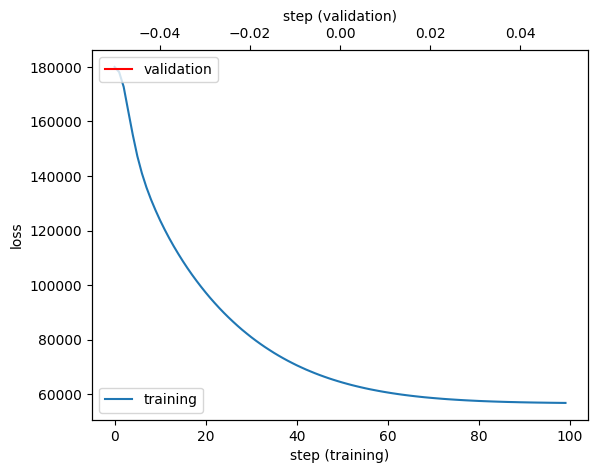

In [42]:
loss_plot(train_loss, [])

In [43]:
vae = VAE("lstm", input_size=20, hidden_size=10, vae_dim=5, num_lstm_layer=3, dropout=0.3, output_length=cutoff_timestep, trajectory_size=(4, 5)).to(device)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("The model has {} parameters.".format(num_params))


lr = 5e-4
num_epochs = 100
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr, weight_decay=1e-5)

pbar = tqdm.notebook.tqdm(
        range(num_epochs), position=0, leave=True,
        bar_format='{l_bar}{bar:30}{r_bar}',
    )


train_loss = []
val_loss = []


for epoch in pbar:
    epoch_loss = 0
    
    vae.train()
    for idx, (X, y) in enumerate(train_dataloader):
        latent_mu, latent_logvar, recon_mu = vae(X)
        loss = vae_loss(latent_mu, latent_logvar, recon_mu, X)
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / len(train_dataloader.dataset))
    print("The training loss is {} on epoch {}.".format(train_loss[-1], epoch))
    
    val_epoch_loss = 0
    vae.eval()
    for idx, (X, y) in enumerate(val_dataloader):
        latent_mu, latent_logvar, recon_mu = vae(X)
        loss = vae_loss(latent_mu, latent_logvar, recon_mu, X)
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        val_epoch_loss += loss.item()
    val_loss.append(val_epoch_loss / len(val_dataloader.dataset))
    print("The val loss is {} on epoch {}.".format(val_loss[-1], epoch))

The model has 13770 parameters.


  0%|                              | 0/100 [00:00<?, ?it/s]

The training loss is 179514.73768382354 on epoch 0.
The val loss is 185477.76666666666 on epoch 0.
The training loss is 177844.31102941177 on epoch 1.
The val loss is 182407.38333333333 on epoch 1.
The training loss is 172446.62389705883 on epoch 2.
The val loss is 174053.50416666668 on epoch 2.
The training loss is 162815.36231617647 on epoch 3.
The val loss is 163818.01875 on epoch 3.
The training loss is 153595.89797794117 on epoch 4.
The val loss is 155366.0125 on epoch 4.
The training loss is 146039.2568014706 on epoch 5.
The val loss is 148450.12708333333 on epoch 5.
The training loss is 139810.60422794116 on epoch 6.
The val loss is 142770.93125 on epoch 6.
The training loss is 134539.65220588236 on epoch 7.
The val loss is 137823.35 on epoch 7.
The training loss is 129856.65275735295 on epoch 8.
The val loss is 133385.92708333334 on epoch 8.
The training loss is 125652.1731617647 on epoch 9.
The val loss is 129336.88541666667 on epoch 9.
The training loss is 121728.73400735293 

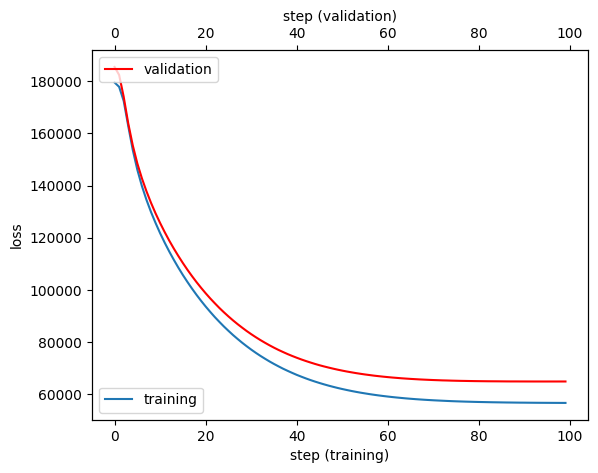

In [44]:
loss_plot(train_loss, val_loss)

In [50]:
Xs.shape
perm_X = Xs.permute(0, 2, 1, 3)
reshaped_X = perm_X.reshape((perm_X.size(0), -1, 20))
reshaped_X.shape
vae_X = vae(reshaped_X)[-1]

In [75]:
vae_reshaped_X = vae_X.reshape((vae_X.size(0), -1, 4, 5))
vae_perm_X = vae_reshaped_X.permute(0, 2, 1, 3)
vae_perm_X

tensor([[[[ 1.1625e+01,  8.5906e+00,  5.4418e-02,  9.3094e-03,  2.1695e+00],
          [ 1.4916e+01,  1.1011e+01,  1.0820e-02, -8.8055e-03,  2.7554e+00],
          [ 1.5427e+01,  1.1387e+01,  4.2296e-03, -1.1047e-02,  2.8478e+00],
          ...,
          [ 1.5518e+01,  1.1454e+01,  3.1058e-03, -1.1530e-02,  2.8645e+00],
          [ 1.5518e+01,  1.1454e+01,  3.1058e-03, -1.1530e-02,  2.8645e+00],
          [ 1.5518e+01,  1.1454e+01,  3.1058e-03, -1.1530e-02,  2.8645e+00]],

         [[ 1.1704e+01,  8.5852e+00, -3.2871e-02,  3.5842e-02,  2.1532e+00],
          [ 1.4988e+01,  1.1000e+01, -3.8741e-03,  6.6234e-03,  2.8022e+00],
          [ 1.5497e+01,  1.1375e+01,  3.2882e-04,  1.7827e-03,  2.9034e+00],
          ...,
          [ 1.5587e+01,  1.1442e+01,  1.0696e-03,  8.1953e-04,  2.9215e+00],
          [ 1.5587e+01,  1.1442e+01,  1.0696e-03,  8.1953e-04,  2.9215e+00],
          [ 1.5587e+01,  1.1442e+01,  1.0696e-03,  8.1953e-04,  2.9215e+00]],

         [[ 1.1527e+01,  8.5395e+00, -1.33

In [70]:
videos[0]
# replace trajectories with vae_perm_X (convert tensor to array)
# save the new videos array has a pickle file

{'name': "D083020_17304100_0_F8_E14_G['LMA', 0, 3, 1]_['LMO', 0, 0, 1]_ST0_2_SZ0_0_0_1_P4_16_7_12_A0_0_C0_0_AN3.46_-2.59_MCTS_L8_R0.0_0.0_PL1_EL1_0_0_s1000_r10_cI1.25_cB1000_e219.mp4",
 'trajectories': [array([[ 1.80000000e+01,  2.00000000e+01,  0.00000000e+00,
           0.00000000e+00, -2.59000000e+00],
         [ 1.81393131e+01,  1.97735874e+01,  3.58233633e+00,
          -5.82210438e+00, -2.58999906e+00],
         [ 1.87363705e+01,  1.88032360e+01,  9.55291004e+00,
          -1.55256035e+01, -2.58999796e+00],
         [ 1.98433670e+01,  1.70583546e+01,  1.63931061e+01,
          -2.37168564e+01, -2.67904639e+00],
         [ 2.14629501e+01,  1.46911839e+01,  2.10068634e+01,
          -3.23199585e+01, -2.89220195e+00],
         [ 2.33090076e+01,  1.14281464e+01,  2.29573563e+01,
          -4.36937897e+01, -2.90554924e+00],
         [ 2.50312080e+01,  7.23037691e+00,  1.29712295e+01,
          -5.48552216e+01, -2.77483301e+00],
         [ 2.49235809e+01,  3.57812610e+00, -5.29332843e+

In [95]:
vae_videos = videos
for video, trajectory in zip(vae_videos, vae_perm_X):
    video["trajectories"] = trajectory.detach().numpy()
vae_videos[0]

{'name': "D083020_17304100_0_F8_E14_G['LMA', 0, 3, 1]_['LMO', 0, 0, 1]_ST0_2_SZ0_0_0_1_P4_16_7_12_A0_0_C0_0_AN3.46_-2.59_MCTS_L8_R0.0_0.0_PL1_EL1_0_0_s1000_r10_cI1.25_cB1000_e219.mp4",
 'trajectories': array([[[ 1.1624692e+01,  8.5906200e+00,  5.4417938e-02,  9.3093924e-03,
           2.1694992e+00],
         [ 1.4915810e+01,  1.1010921e+01,  1.0820448e-02, -8.8055357e-03,
           2.7554080e+00],
         [ 1.5427117e+01,  1.1387013e+01,  4.2296201e-03, -1.1046823e-02,
           2.8477855e+00],
         ...,
         [ 1.5517923e+01,  1.1453844e+01,  3.1058490e-03, -1.1530429e-02,
           2.8644638e+00],
         [ 1.5517923e+01,  1.1453844e+01,  3.1058490e-03, -1.1530429e-02,
           2.8644638e+00],
         [ 1.5517923e+01,  1.1453844e+01,  3.1058490e-03, -1.1530429e-02,
           2.8644638e+00]],
 
        [[ 1.1703915e+01,  8.5852079e+00, -3.2871038e-02,  3.5842106e-02,
           2.1532125e+00],
         [ 1.4988044e+01,  1.1000343e+01, -3.8740784e-03,  6.6233948e-03,
 

In [96]:
file_path = os.path.join("./PHASE", "vae_videos.pickle")
with open(file_path, 'wb') as f:
    pickle.dump(vae_videos, f)